In [246]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import copy
import pickle

from mrsc.src.model.SVDmodel import SVDmodel
from mrsc.src.model.Target import Target
from mrsc.src.model.Donor import Donor
from mrsc.src.synthcontrol.mRSC import mRSC
from mrsc.src.importData import *
import mrsc.src.utils as utils

# from itertools import combinations, product
from statsmodels.tsa.arima_model import ARIMA

def prepareData(stats):
    # transform stats to a dictionary composed of df's for each stat
    # the stats are re-calculated to get one stat for each year
    metricsPerGameColNames = ["PTS","AST","TOV","TRB","STL","BLK","3P"]
    metricsPerGameDict = getMetricsPerGameDict(stats, metricsPerGameColNames)

    metricsPerCentColNames = ["FG","FT"]
    metricsPerCentDict = getMetricsPerCentDict(stats, metricsPerCentColNames)

    metricsWeightedColNames = ["PER"]
    metricsWeightedDict = getMetricsWeightedDict(stats, metricsWeightedColNames)

    allMetricsDict = {**metricsPerGameDict, **metricsPerCentDict, **metricsWeightedDict}
    allPivotedTableDict = getPivotedTableDict(allMetricsDict)
    allMetrics = list(allMetricsDict.keys())
    return allPivotedTableDict, allMetrics

def getActivePlayers(stats, year, buffer):
    # list of name of the players who were active in this and last year
    thisYear = stats[stats.Year == year].copy()
    players = list(thisYear.Player.unique())
    for i in range(1, buffer+1):
        previousYear = stats[stats.Year == (year-i)].copy()
        players = list(set(players) & set(previousYear.Player.unique()))
    return players

def getTopPlayers(stats, year, metric, n):
    stats = stats[stats.Year == year]
    stats = stats.groupby('Player').mean().reset_index()
    stats_sorted = stats[stats.Year == year].sort_values(metric, ascending = False).reset_index(drop=True)
    return stats_sorted[["Player"]][:n]

def getBenchmark(target, metrics_to_use, pred_interval):    
    target_data, nanIndex = target.concat(metrics_to_use)
    num_k = len(metrics_to_use)
    interv_index = int(target_data.shape[1]/num_k - pred_interval)
    total_index = int(interv_index + 1)
    
    # true
    true = utils.get_postint_data(target_data, interv_index, total_index, num_k).T
    true.index = metrics_to_use
    
    # predictions
    history = utils.get_preint_data(target_data, interv_index, total_index, num_k)
    pred = []
    for i in range(num_k):
        pred.append(history.iloc[:,i*interv_index:(i+1)*interv_index].mean(axis=1).to_list())

    pred = pd.DataFrame(pred, index=metrics_to_use, columns = [playerName])
    return true, pred

def getMape(all_true, all_pred):
    mask = (all_true !=0 )
    mape = np.abs(all_pred - all_true) / all_true[mask]
    return (mape.mean(axis=1))

def getR2(true, pred, bench):
    ss_res = pd.DataFrame((true.values - pred.values)**2, index=true.index).sum(axis=1)
    ss_tot = pd.DataFrame((true.values - bench.values)**2, index=true.index).sum(axis=1)
    return (1-ss_res/ss_tot).to_frame(name = pred.columns.values[0])

def getDictionaryGameByGame(data, metrics):
    my_dict = {}
    for i in range(len(metrics)):
        data_pivot = pd.pivot_table(data, values=metrics[i], index="Player", columns = "gmDate")
        shifted_df = data_pivot.apply(lambda x: pd.Series(x.dropna().values), axis=1).fillna(np.nan)
        my_dict.update({metrics[i]: shifted_df})
    return my_dict

def getMonthlyData(data, metrics):
    df = copy.deepcopy(data)
    df.index = df.date
    df_grouped = df.groupby(by =[df.playDispNm,pd.Grouper(freq='M')]).mean()
    
    my_dict = {}
    for i in range(len(metrics)):
        df_pivoted = pd.pivot_table(df_grouped, values = 'playPTS', index='playDispNm', columns="date")
        cols = df_pivoted.columns
        df_pivoted.columns = range(df_pivoted.shape[1])
        my_dict.update({metrics[i]: df_pivoted})
    return my_dict, cols

def printResults(all_pred, all_true,all_R2):
    print(all_pred.shape)
    mask = (all_true !=0 )
    mape = np.abs(all_pred - all_true) / all_true[mask]
    print("*** MAPE ***")
    print(mape.mean(axis=1))
    print("MAPE for all: ", mape.mean().mean())

    rmse = utils.rmse_2d(all_true, all_pred)
    print()
    print("*** RMSE ***")
    print(rmse)
    print("RMSE for all: ", rmse.mean())

    print()
    print("*** R2 ***")
    print(all_R2.mean(axis=1))
    print("R2 for all: ", all_R2.mean(axis=1).mean(axis=0))

    edited_R2 = copy.deepcopy(all_R2)
    edited_R2[edited_R2 <0] = 0
    print()
    print("*** edited R2 ***")
    print(edited_R2.mean(axis=1))
    print("R2 for all: ", edited_R2.mean().mean())

In [22]:
"""
import data
"""
pred_year = 2015 # the year that we are living in
pred_interval = 1 # we are making predictions for pred_year+1 and +2
min_games = 40 # keeps ~72.3%(10096/13963) of the full data

print("*** importing data ***")
### 1. Players
players = pd.read_csv("../data/nba-players-stats/player_data.csv")
players = players[players.year_start >= 1980] # only choose players who started after 1980

### 2. Stats
stats = pd.read_csv("../data/nba-players-stats/Seasons_Stats.csv")
# remove multiple rows for the same [Year, Player]
totals = stats[stats.Tm == "TOT"]
duplicates_removed = stats.drop_duplicates(subset=["Year","Player"], keep=False)
stats = pd.concat([duplicates_removed, totals], axis=0).sort_values("Unnamed: 0")

# fix the name* issue
stats = stats.replace('\*','',regex=True)
stats = stats[stats.Player.isin(players.name)]

# only after 1980
stats = stats[stats.Year >= 1980]

# minimum number of games
stats = stats[stats.G >= min_games]

# without duplicated names --> to do: how to distinguish multiple player with the same name
stats = removeDuplicated(players, stats)
stats.Year = stats.Year.astype(int)
stats.year_count = stats.year_count.astype(int)

print("*** preparing data ***")

########### Donor ##########
# filter stats by the year
stats_donor = stats[stats.Year <= pred_year]
allPivotedTableDict_d, allMetrics = prepareData(stats_donor)
donor = Donor(allPivotedTableDict_d)

########### Target ##########
# filter stats by the year
stats_target = stats[stats.Year <= pred_year+pred_interval]
allPivotedTableDict, allMetrics = prepareData(stats_target)

# just to debug
df_year = pd.pivot_table(stats, values="Year", index="Player", columns = "year_count")

*** importing data ***
*** preparing data ***


In [27]:
"""
targets
"""
activePlayers = getActivePlayers(stats, pred_year+1, buffer=4)
topPlayers = getTopPlayers(stats, pred_year, 'PTS', 300)
topPlayers = topPlayers.values.flatten().tolist()

print("non-rookie active players in 2016: ", len(activePlayers))

# first group
print("***** First Group *****")
target_names_1 = list(set(activePlayers) & set(topPlayers))
max_total_index = 18
print("* not sufficient donor pool:")
for playerName in target_names_1:
    target = Target(playerName, allPivotedTableDict)
    if (target.total_index > max_total_index):
        target_names_1.remove(playerName)
        print(playerName)
print("* total number of target players: ", len(target_names_1))

# second group
print()
print("***** Second Group *****")
target_names_2 = activePlayers
max_total_index = 18
print("* not sufficient donor pool:")
for playerName in target_names_2:
    target = Target(playerName, allPivotedTableDict)
    if (target.total_index > max_total_index):
        target_names_2.remove(playerName)
        print(playerName)
print("* total number of target players: ", len(target_names_2))

##############
# final
yearPlayers = target_names_2

non-rookie active players in 2016:  136
***** First Group *****
* not sufficient donor pool:
Tim Duncan
* total number of target players:  134

***** Second Group *****
* not sufficient donor pool:
Tim Duncan
* total number of target players:  135


In [28]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
metrics_list = [[x] for x in year_metrics]

"""
experiment
"""
print("Yearly Prediction")

year_pred = pd.DataFrame()
year_true = pd.DataFrame()
year_bench = pd.DataFrame()
year_R2 = pd.DataFrame()
for playerName in yearPlayers:
    target = Target(playerName, allPivotedTableDict)
    
    # benchmark
    true_not_used, benchmark = getBenchmark(target, year_metrics, pred_interval)
    
    # prediction
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        pred = mrsc.predict()
        true = mrsc.getTrue()
        if (pred.shape[1] == 1):
            pred.columns = [playerName]
            true.columns = [playerName]
        else:
            pred.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
            true.columns = [playerName+" "+ str(a) for a in range(pred_interval)]
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
    year_pred = pd.concat([year_pred, player_pred], axis=1)
    year_true = pd.concat([year_true, player_true], axis=1)
    year_bench = pd.concat([year_bench, benchmark], axis=1)
    
    R2 = getR2(player_true, player_pred, benchmark)
    year_R2 = pd.concat([year_R2, R2], axis=1)

##################
printResults(year_pred, year_true, year_R2)

Yearly Prediction
(9, 135)
*** MAPE ***
PTS_G    0.283164
AST_G    0.296557
TOV_G    0.276936
TRB_G    0.220741
STL_G    0.270618
BLK_G    0.375914
3P_G     0.633310
FG%      0.063463
FT%      0.061988
dtype: float64
MAPE for all:  0.26825815915081996

*** RMSE ***
PTS_G    3.113604
AST_G    0.932696
TOV_G    0.419533
TRB_G    1.362510
STL_G    0.239959
BLK_G    0.203485
3P_G     0.490664
FG%      0.038089
FT%      0.058718
dtype: float64
RMSE for all:  0.7621398140759544

*** R2 ***
PTS_G    -87.998178
AST_G   -106.237513
TOV_G   -383.405825
TRB_G    -11.313574
STL_G    -39.888154
BLK_G    -10.675517
3P_G     -55.414178
FG%     -437.338500
FT%       -1.328307
dtype: float64
R2 for all:  -125.95552724243966

*** edited R2 ***
PTS_G    0.415672
AST_G    0.434127
TOV_G    0.423864
TRB_G    0.341587
STL_G    0.348934
BLK_G    0.330662
3P_G     0.310874
FG%      0.313764
FT%      0.067343
dtype: float64
R2 for all:  0.33115684958381925


In [29]:
year_pred

,Marvin Williams,Pau Gasol,Marcus Thornton,Jamal Crawford,Shaun Livingston,Chris Bosh,Reggie Jackson,Nick Young,Tyson Chandler,Timofey Mozgov,...,Brandon Bass,Ersan Ilyasova,Monta Ellis,Paul Millsap,LaMarcus Aldridge,Ed Davis,Alonzo Gee,Gary Neal,Mario Chalmers,Ian Mahinmi
PTS_G,6.597869,11.774907,8.202938,10.182324,5.642764,15.368256,16.661918,13.705068,7.691804,9.143238,...,9.569331,11.591829,19.097333,15.699084,20.679063,6.544659,4.325879,9.323694,8.348388,4.013466
AST_G,0.968116,2.681373,0.784503,2.312314,2.280930,1.508651,6.091296,1.105213,0.603819,0.657462,...,1.018765,1.185758,5.295071,2.797423,2.279729,0.832275,0.633691,1.734473,3.377675,0.470654
TOV_G,0.549514,1.534306,0.707254,1.562298,0.978414,1.619369,2.626055,1.029594,1.162426,1.358309,...,0.968176,0.938542,2.834917,1.935300,1.721662,0.628878,0.640871,1.151441,1.811657,0.980004
TRB_G,3.846099,6.302539,1.960763,1.690011,2.112934,6.292066,2.791493,2.239388,6.508996,4.282496,...,4.957269,6.311525,2.998312,7.205176,8.809894,5.774465,3.041293,2.000104,2.335144,3.705984
STL_G,0.607888,0.390808,0.707819,0.710355,0.677788,0.628227,0.920585,0.574881,0.419110,0.301713,...,0.442453,0.748256,1.673666,1.346621,0.775004,0.393527,0.693311,0.381108,1.280595,0.522929
BLK_G,0.327154,1.190683,0.118112,0.160832,0.310500,0.756892,0.135543,0.214365,0.953730,1.062890,...,0.606816,0.199055,0.257296,0.800467,0.944001,0.898825,0.162226,0.004076,0.155540,0.882821
3P_G,1.174990,0.107919,0.710708,1.546937,0.005907,0.967739,0.797208,2.248741,0.000000,-0.032106,...,0.142329,1.031414,1.414592,1.231216,0.573060,0.000000,0.703386,0.390325,0.483183,0.000000
FG%,0.421308,0.483188,0.413871,0.383191,0.454280,0.467325,0.405708,0.404052,0.559423,0.504796,...,0.477902,0.428211,0.431996,0.484148,0.466006,0.540243,0.422684,0.407181,0.408259,0.506866
FT%,0.786849,0.756049,0.827875,0.853639,0.778334,0.791173,0.858053,0.831105,0.636386,0.728037,...,0.828319,0.776242,0.762645,0.721683,0.786057,0.571581,0.754792,0.844123,0.782739,0.587787


# Game by Game Data

In [204]:
print("*** importing data ***")
data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

game_metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
year_metrics = ['PTS_G','AST_G','TOV_G','TRB_G','STL_G','BLK_G','3P_G','FG%','FT%']
colname_dict = {'playPTS': 'PTS_G', 'playAST': 'AST_G', 'playTO':'TOV_G',
                'playFG%': 'FG%','playFT%':'FT%','play3PM':'3P_G',
                'playTRB':'TRB_G','playSTL':'STL_G','playBLK':'BLK_G'}

# edit column names to fit with the yearly data
data = data.rename(columns=colname_dict)

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

stats_game = data[["date","gmDate","playDispNm"]+year_metrics]
stats_game = stats_game.rename(columns={"playDispNm": "Player"})

*** importing data ***


In [205]:
stats_game

,date,gmDate,Player,PTS_G,AST_G,TOV_G,TRB_G,STL_G,BLK_G,3P_G,FG%,FT%
0,2012-10-30 19:00:00,2012-10-30,A.J. Price,7,6,1,2,0,0,2,0.1538,1.0
1,2012-10-30 19:00:00,2012-10-30,Trevor Ariza,9,4,0,3,3,2,2,0.3750,0.5
2,2012-10-30 19:00:00,2012-10-30,Emeka Okafor,10,0,1,7,0,4,0,0.4000,0.5
3,2012-10-30 19:00:00,2012-10-30,Bradley Beal,8,3,2,3,1,0,2,0.2500,1.0
4,2012-10-30 19:00:00,2012-10-30,Trevor Booker,4,1,4,1,1,1,0,0.2222,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
155708,2018-04-11 10:30:00,2018-04-11,JaKarr Sampson,11,0,0,4,0,1,0,0.6250,1.0
155709,2018-04-11 10:30:00,2018-04-11,Buddy Hield,14,5,0,5,2,0,2,0.4615,0.0
155710,2018-04-11 10:30:00,2018-04-11,Nigel Hayes,4,0,0,4,1,1,0,0.4000,0.0
155711,2018-04-11 10:30:00,2018-04-11,Vince Carter,12,1,1,3,0,0,2,0.6250,0.0


# How much variation from yearly prediction?

In [206]:
gamely_variation_mape = pd.DataFrame()
for playerName in yearPlayers:
    # this player
    playerGames = stats_game[stats_game.Player == playerName]

    # 2015-2016 season
    playerGames = playerGames[(playerGames.gmDate <= '2016-04-30') & (playerGames.gmDate >= '2015-10-01')]

    mask = playerGames[year_metrics] != 0
    mae = np.abs(playerGames[year_metrics].sub(year_pred[playerName].values, axis='columns'))/playerGames[year_metrics][mask]
    mape = mae.mean().to_frame(name=playerName)
    gamely_variation_mape = pd.concat([gamely_variation_mape, mape], axis=1)

In [207]:
print("the number of players: ", gamely_variation_mape.shape[1])
print(gamely_variation_mape.mean(axis=1))
print("mean: ", gamely_variation_mape.mean(axis=1).mean())

the number of players:  135
PTS_G    0.764407
AST_G    0.567071
TOV_G    0.451400
TRB_G    0.618544
STL_G    0.459481
BLK_G    0.667463
3P_G     0.579536
FG%      0.345418
FT%      0.284275
dtype: float64
mean:  0.5263995261916803


# Gamely Pred

In [247]:
print("*** setup ***")

# dates
dates_in_season = stats_game[(stats_game.gmDate <= '2016-04-30') & (stats_game.gmDate >= '2015-10-01')].gmDate.unique()

"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics_list = [[x] for x in year_metrics]

*** preparing data ***


In [448]:
########### Donor ##########
# filter stats by the year
donor_data = stats_game[stats_game.date <= pred_date]
donor_dict = getDictionaryGameByGame(donor_data, year_metrics)
donor = Donor(donor_dict)
#############################

mape_year = pd.DataFrame()
mape_game = pd.DataFrame()
mape_ema = pd.DataFrame()
mape_arima = pd.DataFrame()
mape_test = pd.DataFrame()
for date in dates_in_season[30:40]:
# date = dates_in_season[0]
    print(date)
    pred_date = pd.to_datetime(date) # the "clock" that we are living in e.g., '2015-12-01'
    pred_interval_time = pd.Timedelta("1 day") # e.g., if 1 day, we are making predictions for '2015-12-01'

    """ target players"""
    stats_date = stats_game[(stats_game.date > pred_date)&(stats_game.date <= pred_date+pred_interval_time)]
    # getDictionaryGameByGame(data_pred, ['playPTS'])['playPTS']
    gamePlayers = list(stats_date.Player.unique())
    gamePlayers.sort()
    targetPlayers = list(set(gamePlayers)& set(yearPlayers))

    ########### Target ##########
    # filter stats by the year
    target_data = stats_game[stats_game.date <= pred_date + pred_interval_time]
    target_dict = getDictionaryGameByGame(target_data, year_metrics)
    #############################

    playerNamesIncluded =[]
    all_game = pd.DataFrame()
    all_year = pd.DataFrame()
    all_ema = pd.DataFrame()
    all_true = pd.DataFrame()
    all_arima = pd.DataFrame()
    for playerName in targetPlayers:
#         print(playerName)
        target = Target(playerName, target_dict)

        if (donor.concat([year_metrics[0]], target.total_index, method = "sliding").shape[0] <5):
            continue

        playerNamesIncluded = playerNamesIncluded +[playerName]
        pred_interval = 1
        mrsc = mRSC(donor, target, pred_interval, probObservation=1)

        player_year = year_pred.loc[:,playerName].to_frame()
        player_game, player_true, player_ema, player_arima = gameByGame(mrsc, donorSetup, denoiseSetup, regression_method, threshold, verbose, metrics_list)

        all_year = pd.concat([all_year, player_year], axis=1)
        all_game = pd.concat([all_game, player_game], axis=1)
        all_ema = pd.concat([all_ema, player_ema], axis=1)
        all_arima = pd.concat([all_arima, player_arima], axis=1)
        all_true = pd.concat([all_true, player_true], axis=1)

    daily_mape_year = getMape(all_true, all_year).to_frame(name=date)
    daily_mape_game = getMape(all_true, all_game).to_frame(name=date)
    daily_mape_ema = getMape(all_true, all_ema).to_frame(name=date)
    daily_mape_arima = getMape(all_true, all_arima).to_frame(name=date)

    test = 0.8*all_year + 0.01*all_game + 0.09*all_arima
    daily_mape_test = getMape(all_true, test).to_frame(name=date)
    
    mape_year = pd.concat([mape_year,daily_mape_year], axis=1)
    mape_game = pd.concat([mape_game,daily_mape_game], axis=1)
    mape_ema = pd.concat([mape_ema,daily_mape_ema], axis=1)
    mape_arima = pd.concat([mape_arima,daily_mape_arima], axis=1)
    mape_test = pd.concat([mape_test,daily_mape_test], axis=1)

2015-11-27


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


2015-11-28
2015-11-29
2015-11-30


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2015-12-01
2015-12-02


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2015-12-03
2015-12-04
2015-12-05
2015-12-06


/Users/saeyoung/Documents/GitHub/mrsc/venv/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [463]:
mape_year.mean(axis=1).mean()

0.5128084638068734

In [455]:
mape_game.mean().mean()

0.9504761897844958

In [458]:
mape_test.mean().mean()

0.48921287811814834

In [462]:
mape_ema.mean().mean()

0.616050428835543

In [461]:
mape_arima.mean().mean()

0.4967679422777221

In [474]:
mape_test.mean(axis=1)

PTS_G    0.657858
AST_G    0.508874
TOV_G    0.471596
TRB_G    0.566899
STL_G    0.472800
BLK_G    0.633362
3P_G     0.497310
FG%      0.325465
FT%      0.268753
dtype: float64

In [472]:
mape_arima.mean(axis=1)

PTS_G    0.649414
AST_G    0.472357
TOV_G    0.500771
TRB_G    0.624377
STL_G    0.459178
BLK_G    0.554297
3P_G     0.490524
FG%      0.359828
FT%      0.360166
dtype: float64

In [475]:
dates_in_season[30:40]

array(['2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30',
       '2015-12-01', '2015-12-02', '2015-12-03', '2015-12-04',
       '2015-12-05', '2015-12-06'], dtype=object)

In [480]:
stats_game[stats_game.gmDate.isin(dates_in_season[30:40])].date.nunique()

51

In [440]:
for test in [all_year, all_game, all_ema, all_arima]:
    daily_mape = getMape(all_true, test)
    print("**** MAPE ****")
    print(all_mape)
    print(all_mape.mean())
    print()

**** MAPE ****
PTS_G    0.984164
AST_G    0.477659
TOV_G    0.560390
TRB_G    0.625116
STL_G    0.424358
BLK_G    0.642477
3P_G     0.749201
FG%      0.379898
FT%      0.367151
dtype: float64
0.5789348435939788

**** MAPE ****
PTS_G    0.984164
AST_G    0.477659
TOV_G    0.560390
TRB_G    0.625116
STL_G    0.424358
BLK_G    0.642477
3P_G     0.749201
FG%      0.379898
FT%      0.367151
dtype: float64
0.5789348435939788

**** MAPE ****
PTS_G    0.984164
AST_G    0.477659
TOV_G    0.560390
TRB_G    0.625116
STL_G    0.424358
BLK_G    0.642477
3P_G     0.749201
FG%      0.379898
FT%      0.367151
dtype: float64
0.5789348435939788

**** MAPE ****
PTS_G    0.984164
AST_G    0.477659
TOV_G    0.560390
TRB_G    0.625116
STL_G    0.424358
BLK_G    0.642477
3P_G     0.749201
FG%      0.379898
FT%      0.367151
dtype: float64
0.5789348435939788



In [439]:
test = 0.8*all_year + 0.01*all_game + 0.09*all_arima
print(getMape(all_true, test))
print()
print(getMape(all_true, test).mean())

PTS_G    0.783242
AST_G    0.375517
TOV_G    0.586271
TRB_G    0.484240
STL_G    0.415331
BLK_G    0.648619
3P_G     0.627984
FG%      0.350747
FT%      0.244591
dtype: float64

0.5018378897936234


In [427]:
def gameByGame(mrsc, donorSetup, denoiseSetup, regression_method, threshold, verbose, metrics_list):
    player_game = pd.DataFrame()
    player_true = pd.DataFrame()
    player_ema = pd.DataFrame()
    player_arima = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        # compute
        pred = mrsc.predict()
        true = mrsc.getTrue()
        
        # ARIMA
        data = mrsc.target_data.T.ewm(com=0.5).mean().T.values.flatten()
#         data_ema = mrsc.target_data.T.ewm(com=0.5).mean().T
        ema = data[-2]
        data = data[:-1]
        if (np.sum(data != 0)==0):
            pred_arima = 0
        else:
            model = ARMA(data, order=(1, 1))
            model_fit = model.fit(disp=False)
            pred_arima = model_fit.predict(len(data), len(data))
            
#             model = ARIMA(data, order=(1, 1, 1))
#             model_fit = model.fit(disp=False)
#             pred_arima = model_fit.predict(len(data), len(data), typ='levels')

        # edit column names
        pred.columns = [playerName]
        true.columns = [playerName]
        ema = pd.DataFrame(ema, index=metrics_list[i], columns=[playerName])
        pred_arima = pd.DataFrame(pred_arima, index=metrics_list[i], columns=[playerName])

        player_game = pd.concat([player_game, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
        player_ema = pd.concat([player_ema, ema], axis=0)
        player_arima = pd.concat([player_arima, pred_arima], axis=0)
    return player_game, player_true, player_ema, player_arima

In [386]:
data[-2]

0.0

1

In [375]:
data = data[:-1]
ema = data[-2]
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
pred_arima = model_fit.predict(len(data), len(data), typ='levels')


In [376]:
pred_arima

array([-0.00408426])

In [43]:


###################
# print(all_pred)
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())
##############################################################

Game by Game
(9, 38)
*** MAPE ***
PTS_G    0.628574
AST_G    0.535809
TOV_G    0.559121
TRB_G    1.031414
STL_G    0.773948
BLK_G    0.660053
3P_G     0.816975
FG%      0.377339
FT%      0.419069
dtype: float64
MAPE for all:  0.8089024200940415

*** RMSE ***
PTS_G    8.030173
AST_G    1.666410
TOV_G    1.814823
TRB_G    3.433276
STL_G    1.156698
BLK_G    0.847325
3P_G     1.182817
FG%      0.300854
FT%      0.434888
dtype: float64
RMSE for all:  2.0963625940974593


In [46]:
metrics_to_use = year_metrics

print("**** Benchmark ****")
print("total number of players: ", len(playerNamesIncluded))
print("Algo: outputs the mean of the player's history")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in playerNamesIncluded:
    target = Target(playerName, target_dict)
    true, pred = getBenchmark(target, metrics_to_use, pred_interval)
    
    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

# rmse = utils.rmse_2d(true_all, pred_all)
# print()
# print("*** RMSE ***")
# print(rmse)
# print("RMSE for all: ", rmse.mean())    

**** Benchmark ****
total number of players:  38
Algo: outputs the mean of the player's history
-----
*** MAPE ***
PTS_G    0.861568
AST_G    0.603073
TOV_G    0.453542
TRB_G    0.882681
STL_G    0.449850
BLK_G    0.509127
3P_G     0.426773
FG%      0.325951
FT%      0.274276
dtype: float64
MAPE for all:  0.7242542096669778


In [81]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics_list = [[x] for x in year_metrics]

"""
experiment
"""
print("Game by Game")

all_game = pd.DataFrame()
all_year = pd.DataFrame()
all_ema = pd.DataFrame()
all_true = pd.DataFrame()
playerNamesIncluded = []
for playerName in targetOfInterest:
    target = Target(playerName, target_dict)

    interv_index = donor_data[donor_data.playDispNm == playerName].shape[0]
    pred_interval = target.total_index - interv_index
    mrsc = mRSC(donor, target, pred_interval, probObservation=1)

    player_year = year_pred.loc[:,playerName].to_frame()

    playerNamesIncluded = playerNamesIncluded + [playerName]
    player_pred = pd.DataFrame()
    player_true = pd.DataFrame()
    player_ema = pd.DataFrame()
    for i in range(len(metrics_list)):
        mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
        
        # compute
        pred = mrsc.predict()
        true = mrsc.getTrue()
        ema = mrsc.target_data.T.ewm(com=0.5).mean().T.iloc[:,-2].values
        
        # edit column names
        pred.columns = [playerName]
        true.columns = [playerName]
        ema = pd.DataFrame(ema, index=metrics_list[i], columns=[playerName])
        
        player_pred = pd.concat([player_pred, pred], axis=0)
        player_true = pd.concat([player_true, true], axis=0)
        player_ema = pd.concat([player_ema, ema], axis=0)

    all_game = pd.concat([all_game, player_pred], axis=1)
    all_year = pd.concat([all_year, player_year], axis=1)
    all_ema = pd.concat([all_ema, player_ema], axis=1)
    
    all_true = pd.concat([all_true, player_true], axis=1)

Game by Game


In [83]:
all_game

,Marc Gasol,Zaza Pachulia,Mike Conley,Tayshaun Prince,Markieff Morris,Wayne Ellington,Norris Cole,Courtney Lee,Nick Young,Omer Asik,...,Brandon Bass,Devin Harris,Brandon Knight,Roy Hibbert,Matt Barnes,Ed Davis,Joe Johnson,Alonzo Gee,Al-Farouq Aminu,Mario Chalmers
PTS_G,5.290960,15.122661,21.857986,1.578557,12.349032,-4.196681,10.974088,9.819183,16.267822,11.741619,...,8.856245,12.765161,41.642799,9.782678,4.530091,6.796307,10.017599,-0.510932,7.466434,16.434367
AST_G,5.994058,4.098612,9.160739,-2.175792,2.134797,-1.232117,-1.509178,0.242703,-0.852456,0.070036,...,0.817103,-5.823708,9.275232,1.875351,1.750623,-0.342570,3.710145,2.467559,1.056697,3.400080
TOV_G,5.865639,4.595087,1.943831,-1.185846,1.271005,-0.859136,4.251565,0.336542,-1.930999,0.206841,...,1.225686,-2.941251,3.228954,0.039860,2.858376,1.334257,2.288180,2.642183,0.257108,2.788007
TRB_G,7.006584,2.489142,5.407305,5.473040,5.203365,3.552309,3.877272,3.498488,1.736342,8.674202,...,5.561574,0.919083,9.756126,8.615757,7.147606,7.946067,5.912507,-0.055435,-1.376361,1.735113
STL_G,-2.329255,-2.145909,3.327642,1.018023,1.175588,1.567128,-1.276611,0.910868,0.209284,0.869722,...,0.396404,3.303451,-0.592588,0.490911,4.100285,1.225659,1.557473,-5.798280,0.959266,-2.078319
BLK_G,0.011433,-0.810516,-0.355805,1.909368,0.552038,0.154176,-0.473099,0.454373,0.902182,-1.566840,...,0.631418,-0.416007,-0.021935,2.345136,-1.323369,2.604562,0.212079,1.065184,-0.366889,0.183191
3P_G,0.127822,0.000000,1.550724,1.284368,0.455142,0.928926,0.164566,1.930195,7.450873,0.000000,...,0.001865,-3.873787,3.843651,0.095371,2.126969,0.000000,2.465479,0.930928,1.447650,1.659075
FG%,0.494371,1.096096,0.441117,0.372222,0.415076,0.325299,0.796375,0.322244,0.087098,0.958851,...,0.506638,0.243383,0.159370,0.427253,0.173098,0.785026,0.450381,0.011850,0.448198,0.338282
FT%,1.353166,1.226183,0.264597,1.290101,0.500022,0.194795,0.436980,0.578554,1.004874,1.620223,...,0.423287,0.566668,1.877924,0.241087,1.762544,-0.479483,0.812201,0.497748,-0.131917,0.300404


In [84]:
all_year

,Marc Gasol,Zaza Pachulia,Mike Conley,Tayshaun Prince,Markieff Morris,Wayne Ellington,Norris Cole,Courtney Lee,Nick Young,Omer Asik,...,Brandon Bass,Devin Harris,Brandon Knight,Roy Hibbert,Matt Barnes,Ed Davis,Joe Johnson,Alonzo Gee,Al-Farouq Aminu,Mario Chalmers
PTS_G,13.895317,5.095264,14.215731,9.079782,16.190110,6.429999,6.809064,8.251007,13.705068,8.107566,...,9.569331,10.043811,17.626105,10.546835,8.185503,6.544659,11.417163,4.325879,6.079063,8.348388
AST_G,3.665411,1.357569,5.549596,2.018950,2.331018,1.005572,3.415285,1.591848,1.105213,0.835773,...,1.018765,4.238338,5.175817,1.175345,1.532866,0.832275,3.384802,0.633691,1.113140,3.377675
TOV_G,1.759681,1.151376,2.001903,0.760014,2.134651,0.419364,1.253217,0.907813,1.029594,1.455427,...,0.968176,1.739344,2.778799,1.746743,1.084232,0.628878,1.719363,0.640871,0.834746,1.811657
TRB_G,6.842644,4.100508,2.477611,3.078336,5.097594,2.081991,1.689186,2.086300,2.239388,7.152907,...,4.957269,1.755495,3.308086,7.654390,3.310423,5.774465,2.779794,3.041293,4.940593,2.335144
STL_G,0.860280,0.554323,1.623292,0.418489,1.134562,0.473808,0.813375,0.847215,0.574881,0.384453,...,0.442453,0.865714,1.294656,0.345930,0.612443,0.393527,0.668372,0.693311,1.014897,1.280595
BLK_G,1.271042,0.225766,0.186841,0.281530,0.472999,0.044696,0.162636,0.206367,0.214365,0.738335,...,0.606816,0.140695,0.181085,1.834058,0.473031,0.898825,0.108816,0.162226,0.693119,0.155540
3P_G,0.054738,0.000000,1.271771,0.459685,1.016646,1.523129,0.663608,1.272650,2.248741,0.000000,...,0.142329,0.981618,2.388133,-0.007918,1.675136,0.000000,1.532471,0.703386,0.506772,0.483183
FG%,0.495044,0.433906,0.424003,0.427768,0.431532,0.406377,0.402773,0.435455,0.404052,0.517705,...,0.477902,0.412266,0.408943,0.450454,0.425114,0.540243,0.416069,0.422684,0.423159,0.408259
FT%,0.757900,0.734528,0.796642,0.732989,0.753088,0.847764,0.732218,0.844882,0.831105,0.545376,...,0.828319,0.785448,0.794385,0.743814,0.727999,0.571581,0.796376,0.754792,0.728559,0.782739


In [85]:
all_ema

,Marc Gasol,Zaza Pachulia,Mike Conley,Tayshaun Prince,Markieff Morris,Wayne Ellington,Norris Cole,Courtney Lee,Nick Young,Omer Asik,...,Brandon Bass,Devin Harris,Brandon Knight,Roy Hibbert,Matt Barnes,Ed Davis,Joe Johnson,Alonzo Gee,Al-Farouq Aminu,Mario Chalmers
PTS_G,10.208545,12.994639,19.045575,1.641906,8.569444,8.194136,10.766148,6.518842,16.677565,0.727674,...,7.133106e+00,9.599807,18.219277,7.107133e+00,13.429295,10.817790,13.319024,6.017407,6.541133,4.899801
AST_G,2.778297,1.249307,5.918388,0.309528,1.907748,0.085801,1.799662,1.041809,0.814883,0.000013,...,1.154603e+00,1.698388,4.798525,1.219862e+00,3.651594,1.334469,1.310387,1.901743,2.149943,2.241251
TOV_G,2.965227,2.640848,4.162448,0.231407,2.389994,2.000305,0.250960,2.697839,0.039562,0.777326,...,1.311981e-02,0.425248,0.323868,1.022380e+00,0.201238,0.561956,3.859102,0.844749,1.772516,3.294221
TRB_G,10.647622,9.709786,3.073873,0.942215,6.875589,4.094762,0.463907,1.701413,1.715566,3.946371,...,3.836318e+00,1.376090,4.653483,8.070325e+00,6.589733,8.730572,4.578930,2.945504,7.404761,2.498756
STL_G,0.776474,0.705492,0.718605,0.074379,0.258330,0.080280,2.008637,0.835376,0.231809,0.000963,...,5.795621e-03,0.736562,1.900733,7.521211e-01,1.474362,0.444840,0.547192,1.493329,0.011394,0.802474
BLK_G,2.791654,0.247851,1.341564,0.008232,0.085061,0.666667,0.790225,0.003116,0.000038,0.076016,...,2.524005e-01,0.002959,0.669430,1.517286e+00,0.674922,0.823693,0.000004,0.077736,0.118320,0.000339
3P_G,0.000135,0.000000,1.223109,0.000011,0.502374,0.691769,0.258625,0.453089,4.539956,0.000000,...,3.238566e-14,0.743620,1.936329,2.872743e-66,1.559471,0.000000,1.203717,0.002777,0.790724,0.671036
FG%,0.476090,0.616467,0.429145,0.105746,0.299108,0.505631,0.522545,0.515060,0.409584,0.222287,...,6.569780e-01,0.581056,0.391700,5.179737e-01,0.494165,0.565575,0.396848,0.610947,0.228913,0.304854
FT%,0.592578,0.807885,0.915487,0.074074,0.810066,0.704618,0.700978,0.713001,0.003664,0.140584,...,1.916679e-01,0.729483,0.896560,7.207411e-01,0.355388,0.568166,0.981304,0.024691,0.206874,0.267764


In [114]:
getMape(all_true, all_game)

PTS_G    0.950121
AST_G    1.378406
TOV_G    0.901412
TRB_G    1.183919
STL_G    2.153979
BLK_G    0.846668
3P_G     1.466755
FG%      0.678056
FT%      0.851672
dtype: float64

In [116]:
getMape(all_true, all_ema)

PTS_G    0.609560
AST_G    0.516223
TOV_G    0.535440
TRB_G    1.141061
STL_G    0.493619
BLK_G    0.657786
3P_G     0.693733
FG%      0.386201
FT%      0.416267
dtype: float64

In [118]:
getMape(all_true, all_year)

PTS_G    0.909969
AST_G    0.613891
TOV_G    0.479549
TRB_G    0.806368
STL_G    0.421075
BLK_G    0.563402
3P_G     0.525287
FG%      0.318179
FT%      0.212907
dtype: float64

In [109]:
all_pred = 0.3*all_year + 0.7*all_ema
getMape(all_true, all_pred)

PTS_G    0.677908
AST_G    0.450457
TOV_G    0.495817
TRB_G    1.023327
STL_G    0.459596
BLK_G    0.585299
3P_G     0.605758
FG%      0.343855
FT%      0.312298
dtype: float64

In [110]:
getMape(all_true, all_pred).mean()

0.5504795061542529

In [112]:
getR2(all_true, all_pred, all_ema)

,Marc Gasol
PTS_G,0.039198
AST_G,0.186162
TOV_G,0.115607
TRB_G,-0.035481
STL_G,0.087450
BLK_G,0.117637
3P_G,0.139718
FG%,0.063501
FT%,0.091864


In [87]:
getR2(true, pred, bench)

In [79]:
###################
# print(all_pred)
mask = (all_true !=0 )

print("*** MAPE 1 ***")
mape1 = np.abs(all_pred1 - all_true) / all_true[mask]
print(mape1.mean(axis=1))
print("MAPE for all: ", mape1.mean().mean())

print("*** MAPE 2 ***")
mape2 = np.abs(all_pred2 - all_true) / all_true[mask]
print(mape2.mean(axis=1))
print("MAPE for all: ", mape2.mean().mean())

print("*** MAPE 3 ***")
mape3 = np.abs(all_pred3 - all_true) / all_true[mask]
print(mape3.mean(axis=1))
print("MAPE for all: ", mape3.mean().mean())
##############################################################

,Mario Chalmers
PTS_G,16.434367
AST_G,3.400080
TOV_G,2.788007
TRB_G,1.735113
STL_G,-2.078319
BLK_G,0.183191
3P_G,1.659075
FG%,0.338282
FT%,0.300404


In [57]:
# print(all_pred)
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_ema - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())


(9, 66)
*** MAPE ***
playPTS    0.481619
playAST    0.707849
playTO     0.679481
playFG%    0.368872
playFT%    0.446733
play3PM    0.547123
playTRB    0.688736
playSTL    0.674008
playBLK    0.702169
dtype: float64
MAPE for all:  0.5977232532961072


In [52]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"fixed", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
metrics_list = [[x] for x in metrics]

playerName = targetOfInterest[2]
print(playerName)

target = Target(playerName, target_dict)
print("*** target - total index: ", target.total_index)
#     print(target.concat(metrics_list[1])[0])

interv_index = donor_data[donor_data.playDispNm == playerName].shape[0]
pred_interval = target.total_index - interv_index
mrsc = mRSC(donor, target, pred_interval, probObservation=1)

player_pred = pd.DataFrame()
player_true = pd.DataFrame()
for i in range(len(metrics_list)):
    mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
    pred = mrsc.predict()
    true = mrsc.getTrue()
    print(pred)
    ema = mrsc.target_data.T.ewm(com=0.5).mean().T.iloc[:,-2].values
    pred = 0.5*pred + 0.5*ema
    print(pred)
    pred.columns = [playerName +" "+ str(a) for a in range(pred_interval)]
    true.columns = [playerName +" "+ str(a) for a in range(pred_interval)]
    
    player_pred = pd.concat([player_pred, pred], axis=0)
    player_true = pd.concat([player_true, true], axis=0)
    
#     print(metrics_list[i])
#     print(mrsc.target_data.T.ewm(com=0.5).mean().T.iloc[:,-2].values)
#     print(true.values)
    
print(player_pred)
print(player_true)

Tony Parker
*** target - total index:  16
                 0
playPTS  21.305132
                 0
playPTS  18.710978
                0
playAST -2.475888
                0
playAST  1.997595
                0
playTO  10.482741
               0
playTO  5.556103
                0
playFG%  0.248384
                0
playFG%  0.388637
               0
playFT% -3.13075
                0
playFT% -1.110127
                0
play3PM  0.082531
                0
play3PM  0.083791
               0
playTRB  4.22459
                0
playTRB  2.920978
                0
playSTL  0.735368
                0
playSTL  0.433088
               0
playBLK -1.27611
                0
playBLK -0.637903
         Tony Parker 0
playPTS      18.710978
playAST       1.997595
playTO        5.556103
playFG%       0.388637
playFT%      -1.110127
play3PM       0.083791
playTRB       2.920978
playSTL       0.433088
playBLK      -0.637903
         Tony Parker 0
playPTS          30.00
playAST           6.00
playTO         

Al Jefferson


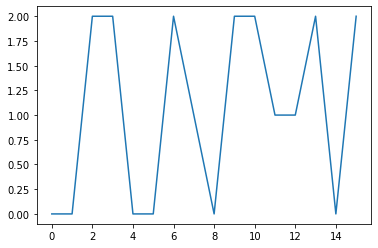

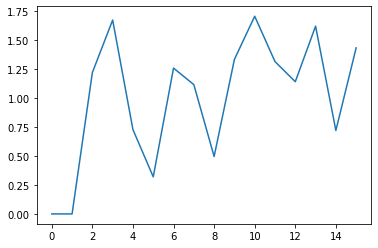

Alonzo Gee


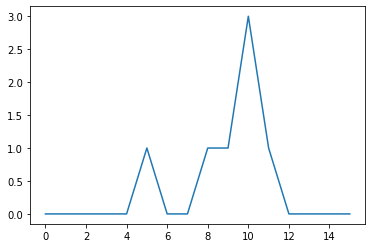

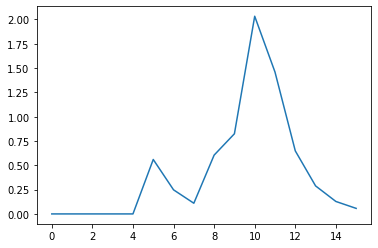

Amir Johnson


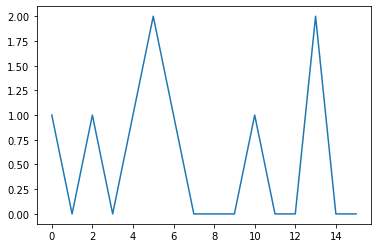

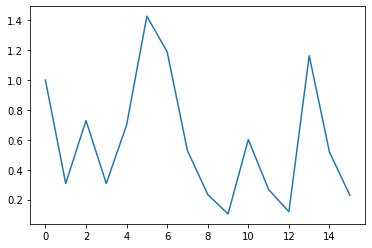

Andre Drummond


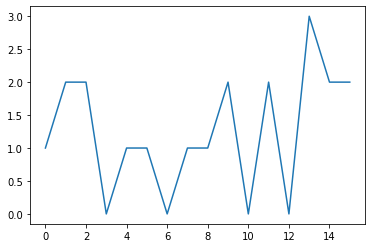

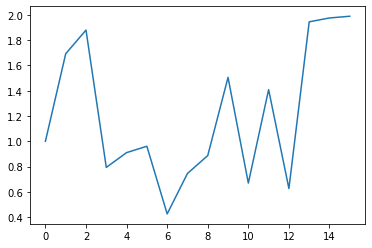

Andre Iguodala


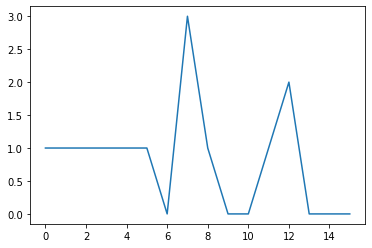

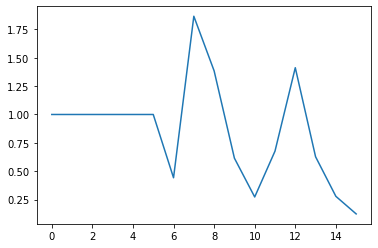

In [29]:
for i in range(5):
    print(mrsc.donor_data.index[i])
    a = mrsc.donor_data
    plt.plot(a.iloc[i,:])
    plt.show()
    b = mrsc.donor_data.T.ewm(com=0.8).mean().T
    plt.plot(b.iloc[i,:])
    plt.show()

In [46]:
mrsc.target_data.T.ewm(com=0.5).mean().T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
playDispNm,,,,,,,,,,,,,,,,
Tony Parker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666768,0.222234,0.074075,0.024691,0.00823,0.002743,0.000914,0.000305,0.666768


In [50]:
a = mrsc.target_data.iloc[:,:13]
a.T.ewm(com=0.5).mean().T

,0,1,2,3,4,5,6,7,8,9,10,11,12
playDispNm,,,,,,,,,,,,,
Tony Parker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666768,0.222234,0.074075,0.024691,0.00823,0.002743


# Monthly?

In [11]:
"""
import data
"""
print("*** importing data ***")
data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

print("*** preparing data ***")

pred_date = pd.to_datetime('2013-10-31') # the year that we are living in
pred_interval = 3
pred_interval_time = pd.Timedelta("30 days") * pred_interval # we are making predictions for pred_year+1 and +2


########### Donor ##########
# filter stats by the year
donor_data = data[data.date <= pred_date]
donor_dict, cols_donor = getMonthlyData(donor_data, metrics)
donor = Donor(donor_dict)

########### Target ##########
# filter stats by the year
target_data = data[data.date <= pred_date + pred_interval_time]
target_dict, cols_target = getMonthlyData(target_data, metrics)

print()
print("targte columns")
print(cols_target)
print("donor columns")
print(cols_donor)

*** importing data ***
*** preparing data ***

targte columns
DatetimeIndex(['2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-31', '2013-04-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31'],
              dtype='datetime64[ns]', name='date', freq=None)
donor columns
DatetimeIndex(['2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-31', '2013-04-30', '2013-10-31'],
              dtype='datetime64[ns]', name='date', freq=None)


In [14]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
metrics_list = [[x] for x in metrics]

"""
experiment
"""
print("1 metric at once")

all_pred = pd.DataFrame()
all_true = pd.DataFrame()
# for playerName in playerNames:
playerName = allPlayers[123]
# print(playerName)
# print("*** year - year_count matching for this player")
# a = df_year[df_year.index == playerName]
# print(a.dropna(axis=1))

target = Target(playerName, target_dict)
# print("*** target - total index: ", target.total_index)
# print(target.concat(metrics_list[1]))

interv_index = donor_data[donor_data.playDispNm == playerName].shape[0]
pred_interval = target.total_index - interv_index
mrsc = mRSC(donor, target, pred_interval, probObservation=1)

# if (donor.concat([metrics[0]], target.total_index, method = "sliding").shape[0] <5):
#     continue

player_pred = pd.DataFrame()
player_true = pd.DataFrame()
for i in range(len(metrics_list)):
    mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
    pred = mrsc.predict()
    true = mrsc.getTrue()
    pred.columns = [playerName +" "+ str(a) for a in range(pred_interval)]
    true.columns = [playerName +" "+ str(a) for a in range(pred_interval)]
    player_pred = pd.concat([player_pred, pred], axis=0)
    player_true = pd.concat([player_true, true], axis=0)
all_pred = pd.concat([all_pred, player_pred], axis=1)
all_true = pd.concat([all_true, player_true], axis=1)

###################
# print(all_pred)
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())
##############################################################

1 metric at once


Exception: Donor pool size too small. Donor pool size: Gustavo Ayon(0, 9)

# Benchmark

In [78]:
# metrics_to_use= ["PTS_G","AST_G","TOV_G","PER_w", "FG%","FT%","3P_G","TRB_G","STL_G","BLK_G"]
metrics_to_use = allMetrics

print("Algo: outputs the mean of the player's history")
print("-----")
pred_all = pd.DataFrame()
true_all = pd.DataFrame()
for playerName in playerNames:
    target = Target(playerName, allPivotedTableDict)
    true, pred = getBenchmark(target, metrics_to_use, pred_interval)
    
    pred_all = pd.concat([pred_all, pred], axis=1)
    true_all = pd.concat([true_all, true], axis=1)

###################
mask = (true_all !=0 )
mape = np.abs(pred_all - true_all) / true_all[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(true_all, pred_all)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())    

Algo: outputs the mean of the player's history
-----
*** MAPE ***
PTS_G    0.413246
AST_G    0.387396
TOV_G    0.400230
TRB_G    0.275911
STL_G    0.320220
BLK_G    0.454082
3P_G     0.533344
FG%      0.063127
FT%      0.061047
PER_w    0.202120
dtype: float64
MAPE for all:  0.306121947982417

*** RMSE ***
PTS_G    4.409235
AST_G    1.131206
TOV_G    0.564801
TRB_G    1.450656
STL_G    0.274086
BLK_G    0.235605
3P_G     0.466516
FG%      0.036495
FT%      0.057969
PER_w    3.312910
dtype: float64
RMSE for all:  1.1939480121133492


In [33]:
for metric in allMetrics:
    print()
    print(metric)
    print(mape.loc[metric,:].sort_values(ascending = False)[:10])


PTS_G
Tyler Hansbrough 0    2.60442
Kirk Hinrich 0        2.54157
Nick Collison 0       2.40373
Tayshaun Prince 0     1.82742
Ty Lawson 0           1.48293
Jason Thompson 0      1.42104
Brandon Jennings 0    1.19949
Steve Blake 0         1.19918
Jonas Jerebko 0       1.19298
Beno Udrih 0          1.15311
Name: PTS_G, dtype: object

AST_G
Anthony Morrow 0       7.07181
Tyler Hansbrough 0     5.93413
Nick Young 0            3.7168
Bismack Biyombo 0      3.34997
Wesley Johnson 0       2.60229
DeAndre Jordan 0       2.04812
Enes Kanter 0          2.00037
Richard Jefferson 0    1.92116
C.J. Miles 0           1.85656
Anthony Tolliver 0     1.66044
Name: AST_G, dtype: object

TOV_G
Anthony Morrow 0       5.14906
Tyler Hansbrough 0     3.34793
Anthony Tolliver 0     2.25923
Jason Thompson 0       2.25143
Tayshaun Prince 0      2.21373
Nick Young 0           1.68462
Kirk Hinrich 0         1.34559
Wayne Ellington 0      1.31643
Richard Jefferson 0    1.18031
Gary Neal 0            1.16256
Name:

In [717]:
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1).reindex(allMetrics))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse.reindex(allMetrics))
print("RMSE for all: ", rmse.mean())

print()
print("*** R2 ***")
print(all_R2.mean(axis=1).reindex(allMetrics))
print("R2 for all: ", all_R2.mean(axis=1).mean(axis=0))
##############################################################

(10, 99)
*** MAPE ***
PTS_G    0.274777
AST_G    0.537414
TOV_G    0.309435
TRB_G    0.181637
STL_G    0.231816
BLK_G    0.374646
3P_G     1.778391
FG%      0.071516
FT%      0.099925
PER_w    0.190299
dtype: float64
MAPE for all:  0.38260637091850613

*** RMSE ***
PTS_G    5.052958
AST_G    1.798591
TOV_G    0.700045
TRB_G    1.167430
STL_G    0.234047
BLK_G    0.190006
3P_G     0.780453
FG%      0.051968
FT%      0.093497
PER_w    4.362244
dtype: float64
RMSE for all:  1.4431239627611094

*** R2 ***
PTS_G    -65.290399
AST_G   -178.406691
TOV_G    -68.639120
TRB_G      0.755287
STL_G      0.998910
BLK_G     -6.225443
3P_G    -116.758836
FG%        0.999972
FT%      -24.373353
PER_w     -3.446957
dtype: float64
R2 for all:  -46.03866302248279


# Monthly

In [12]:
def getMonthlyData(data, metrics):
    df = copy.deepcopy(data)
    df.index = df.date
    df_grouped = df.groupby(by =[df.playDispNm,pd.Grouper(freq='M')]).mean()
    
    my_dict = {}
    for i in range(len(metrics)):
        df_pivoted = pd.pivot_table(df_grouped, values = 'playPTS', index='playDispNm', columns="date")
        cols = df_pivoted.columns
        df_pivoted.columns = range(df_pivoted.shape[1])
        my_dict.update({metrics[i]: df_pivoted})
    return my_dict, cols

In [13]:
"""
import data
"""
print("*** importing data ***")
data = pd.read_csv("../data/nba-enhanced-stats/2012-18_playerBoxScore.csv")

metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']

date_col = pd.to_datetime(data.gmDate + " " + data.gmTime, format='%Y-%m-%d %H:%M').rename("date")
data = pd.concat([date_col,data], axis=1)

print("*** preparing data ***")

pred_date = pd.to_datetime('2013-10-31') # the year that we are living in
pred_interval = 3
pred_interval_time = pd.Timedelta("30 days") * pred_interval # we are making predictions for pred_year+1 and +2


########### Donor ##########
# filter stats by the year
donor_data = data[data.date <= pred_date]
donor_dict, cols_donor = getMonthlyData(donor_data, metrics)
donor = Donor(donor_dict)

########### Target ##########
# filter stats by the year
target_data = data[data.date <= pred_date + pred_interval_time]
target_dict, cols_target = getMonthlyData(target_data, metrics)

print()
print("targte columns")
print(cols_target)
print("donor columns")
print(cols_donor)

*** importing data ***


*** preparing data ***

targte columns
DatetimeIndex(['2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-31', '2013-04-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31'],
              dtype='datetime64[ns]', name='date', freq=None)
donor columns
DatetimeIndex(['2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-31', '2013-04-30', '2013-10-31'],
              dtype='datetime64[ns]', name='date', freq=None)


In [15]:
""" target """
data_pred = data[(data.date > pred_date)&(data.date <= pred_date+pred_interval_time)]
# getDictionaryGameByGame(data_pred, ['playPTS'])['playPTS']
allPlayers = list(data_pred.playDispNm.unique())
allPlayers.sort()
print(len(allPlayers))

452


In [16]:
np.sum((target_dict['playPTS'].index).isin(playerNames))

95

In [20]:
"""
experiment setup
"""
# overall setup
donorSetup= [None,"sliding", True]
denoiseSetup = ["SVD", "all"]
regression_method = "pinv"

threshold = 0.97
verbose = False

metrics = ['playPTS', 'playAST', 'playTO','playFG%','playFT%','play3PM','playTRB','playSTL', 'playBLK']
metrics_list = [[x] for x in metrics]

"""
experiment
"""
print("1 metric at once")

all_pred = pd.DataFrame()
all_true = pd.DataFrame()
# for playerName in playerNames:
playerName = playerNames[0]
# print(playerName)
# print("*** year - year_count matching for this player")
# a = df_year[df_year.index == playerName]
# print(a.dropna(axis=1))

target = Target(playerName, target_dict)
# print("*** target - total index: ", target.total_index)
# print(target.concat(metrics_list[1]))

interv_index = donor_data[donor_data.playDispNm == playerName].shape[0]
pred_interval = target.total_index - interv_index
mrsc = mRSC(donor, target, pred_interval, probObservation=1)

# if (donor.concat([metrics[0]], target.total_index, method = "sliding").shape[0] <5):
#     continue

player_pred = pd.DataFrame()
player_true = pd.DataFrame()
for i in range(len(metrics_list)):
    mrsc.fit_threshold(metrics_list[i], threshold, donorSetup, denoiseSetup,regression_method, verbose)
    pred = mrsc.predict()
    true = mrsc.getTrue()
    pred.columns = [playerName +" "+ str(a) for a in range(pred_interval)]
    true.columns = [playerName +" "+ str(a) for a in range(pred_interval)]
    player_pred = pd.concat([player_pred, pred], axis=0)
    player_true = pd.concat([player_true, true], axis=0)
all_pred = pd.concat([all_pred, player_pred], axis=1)
all_true = pd.concat([all_true, player_true], axis=1)

###################
# print(all_pred)
print(all_pred.shape)
mask = (all_true !=0 )
mape = np.abs(all_pred - all_true) / all_true[mask]
print("*** MAPE ***")
print(mape.mean(axis=1))
print("MAPE for all: ", mape.mean().mean())

rmse = utils.rmse_2d(all_true, all_pred)
print()
print("*** RMSE ***")
print(rmse)
print("RMSE for all: ", rmse.mean())
##############################################################

1 metric at once


Exception: Donor pool size too small. Donor pool size: Tony Allen(0, 11)

In [ ]:

# metrics = ['playPTS', 'playAST', 'playTO', 'playSTL', 'playBLK',
#        'playPF', 'playFGA', 'playFGM', 'playFG%', 'play2PA', 'play2PM',
#        'play2P%', 'play3PA', 'play3PM', 'play3P%', 'playFTA', 'playFTM',
#        'playFT%', 'playORB', 'playDRB', 'playTRB']
